https://chat.openai.com/share/98bd9fe3-f8ae-4ff4-859a-dd4a7855c429

In [1]:
from dendropy.simulate import treesim
import dendropy
from Bio import Phylo
from io import StringIO
import Bio.Phylo.BaseTree
import numpy as np
import random
import matplotlib.pyplot as plt
import torch 
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Generate birth death trees

In [59]:
#birth_death_tree returns a tree generated under a continuous-time birth-death process, with branch lengths in arbitrary time units.
t_cont= treesim.birth_death_tree(birth_rate=1.0, death_rate=0.2, num_total_tips=15, repeat_until_success=True)
t_cont.print_plot()

                                                              /------------ T2 
/-------------------------------------------------------------+                
|                                                             \------------ T9 
|                                                                              
+                                                             /------------ T3 
|           /-------------------------------------------------+                
|           |                                                 \------------ T8 
|           |                                                                  
\-----------+                                                 /------------ T10
            |            /------------------------------------+                
            |            |                                    \------------ T1 
            |            |                                                     
            \------------+              

# Convert to Newick string

In [3]:
newick_str = t_cont.as_string(schema="newick")
file = StringIO(newick_str)
bio_phylo_tree = Phylo.read(file, "newick")

# Get node living data

In [4]:
def get_living_times(tree, node, name_num=0, Dist = {}):
    if node == tree.root:
        node.name = "C"+str(name_num)
        Dist[node.name] = [0,0]
    if len(node.clades)!=0:
        for child in node.clades:
            if (child.name==None):
                child.name = "C"+ str(name_num)
                name_num += 1
            dist = Dist[node.name][1]
            Dist[child.name] = [dist,dist + child.branch_length]
            get_living_times(tree, child, name_num+1)
    return Dist

In [5]:
print(get_living_times(bio_phylo_tree, bio_phylo_tree.root))

{'C0': [0, 0.7033978918493721], 'C2': [0.7033978918493721, 0.7312750375403062], 'T9': [0.7312750375403062, 1.6946619249077006], 'T5': [0.7312750375403062, 1.6946619249077006], 'C3': [1.1436437894689602, 1.8864960152261083], 'T10': [0.9394163610382391, 1.6946619249077006], 'T1': [0.9394163610382391, 1.6946619249077004], 'C1': [0.7033978918493721, 1.1436437894689602], 'T3': [1.1436437894689602, 2.3980598167570726], 'T7': [1.8864960152261083, 2.3980598167570726], 'C5': [1.8864960152261083, 2.0890110625231264], 'C7': [2.0890110625231264, 2.181575231879988], 'C9': [2.181575231879988, 2.3980598167570726], 'T8': [2.3980598167570726, 2.3980598167570726], 'T6': [2.3980598167570726, 2.3980598167570726], 'T2': [2.181575231879988, 2.3980598167570726], 'T4': [2.0890110625231264, 2.3980598167570726]}


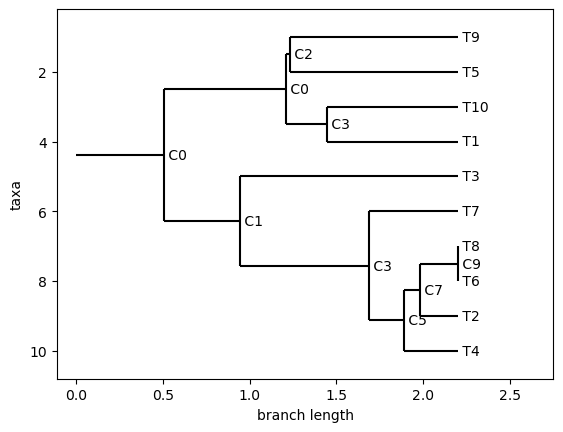

In [6]:
Phylo.draw(bio_phylo_tree)

# Collapse Tree - Trial run

In [27]:
#just using arbitrary bias and weights rn for testing
bias = np.array([[1],[1]])
weights = np.array([[0.5,0.1, 0.2, 0.2],[0.3,0.2, 0.1, 0.6]])
living_dict = get_living_times(bio_phylo_tree, bio_phylo_tree.root)

#turn dictionary of birth & death of nodes in list format into np vector format
def vectorize_dict(D):
    for node, [birth, death] in D.items():
        D[node] = np.array([birth, death]).reshape(2, 1)
    return D

living_dict = vectorize_dict(living_dict)

In [29]:
# collapse all living times to 1 vector
def collapse_tree(living_dict, tree, node):
    if len(node.clades)==0:
        #leaf node
        return living_dict[node.name]
    else:
        result = np.concatenate((collapse_tree(living_dict, tree, node.clades[0]), collapse_tree(living_dict, tree, node.clades[1])), axis=0)
        return np.add(np.matmul(weights,result), bias)

In [30]:
print(collapse_tree(living_dict, bio_phylo_tree, bio_phylo_tree.root))

[[10.18012713]
 [12.75030665]]


# Generate tree dataset

In [61]:
simulated_trees = []
matching_parameters = []
MIN_LEAVES = 500
MAX_LEAVES = 1000


for i in range(0,10000):
    #rate_birth = random.random()
    rate_death = random.random()
    num_leaves = random.randint(MIN_LEAVES,MAX_LEAVES)
    t_cont= treesim.birth_death_tree(birth_rate=1.0, death_rate=rate_death, num_total_tips=num_leaves)
    simulated_trees.append(t_cont)
    matching_parameters.append([1.0,rate_death])

In [62]:
bio_phylo_simulated_trees = []

#convert newick trees into bio phylo tree objects
for tree in simulated_trees:
    newick_str = tree.as_string(schema="newick")
    file = StringIO(newick_str)
    bio_phylo_tree = Phylo.read(file, "newick")
    bio_phylo_simulated_trees.append(bio_phylo_tree)
    

In [63]:
x,y = bio_phylo_simulated_trees, matching_parameters

y=np.array(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=5)
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))
y_train.requires_grad_(True)
y_test.requires_grad_(True)

tensor([[1.0000, 0.0905],
        [1.0000, 0.5297],
        [1.0000, 0.0391],
        ...,
        [1.0000, 0.8479],
        [1.0000, 0.3707],
        [1.0000, 0.2676]], requires_grad=True)

# Neural network

In [64]:
class treeProcessor(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(treeProcessor, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, living_dict):
        if len(x.clades) == 0:
            # Terminal node
            survival = living_dict[x.name]
            temp = torch.tensor(survival, dtype=torch.float32)
            temp = temp.reshape(1, 2)
            return temp.detach().clone()  # Use .detach().clone() to create a new tensor without grad

        L_collapsed = self.forward(x.clades[0], living_dict).detach().clone()
        L_collapsed = L_collapsed.reshape(2, 1)
        
        R_collapsed = self.forward(x.clades[1], living_dict).detach().clone()
        R_collapsed = R_collapsed.reshape(2, 1)

        result = torch.cat((L_collapsed, R_collapsed), dim=0)
        result = result.reshape(1, 4)

        return (self.sigmoid(self.linear(result))).reshape(2, 1)

In [36]:
hi = treeProcessor(4,10,2)


In [37]:
d = vectorize_dict(get_living_times(bio_phylo_tree, bio_phylo_tree.root))
hi(bio_phylo_tree.root, d)

tensor([[0.4249],
        [0.4546]], grad_fn=<ViewBackward0>)

In [65]:
class myModel(nn.Module):
    def __init__(self, input_dim: int, 
               hidden_dim: int, output_dim: int):
        super(myModel,self).__init__()
        self.recursive_tree_processor = treeProcessor(4, 4, 2)
        self.myModel=nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self,tree):
        dict = vectorize_dict(get_living_times(tree, tree.root))
        x=self.myModel((self.recursive_tree_processor(tree.root,dict)).reshape(1,2))
        x.requires_grad_(True)
        return x

In [66]:
input_dim = 2
hidden_dim = 10
batch_size = 5
num_workers = 4
output_dim = 2

model = myModel(input_dim, hidden_dim, output_dim)
print(model)

myModel(
  (recursive_tree_processor): treeProcessor(
    (linear): Linear(in_features=4, out_features=2, bias=True)
    (sigmoid): Sigmoid()
  )
  (myModel): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=10, out_features=2, bias=True)
  )
)


In [67]:
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [68]:
e = []
l = []

for epoch in range(30):
    total_loss = 0  # Initialize total loss for the epoch
    for param in model.parameters():
        param.requires_grad_(True)
    
    for i in range(len(x_train)):
        predict_y = model(x_train[i]).squeeze(0)
        loss = loss_func(predict_y, y_train[i])
        total_loss += loss.item()

        # Backward and optimization steps
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        predict_y.detach()

    # Print average loss for the epoch
    avg_loss = total_loss / len(x_train)
    print(f'Epoch {epoch}, Average Loss: {avg_loss}')

    # Append to lists for plotting or analysis
    e.append(epoch)
    l.append(avg_loss)

Epoch 0, Average Loss: 0.04221385568497375
Epoch 1, Average Loss: 0.041691734581679324
Epoch 2, Average Loss: 0.041685686783521664
Epoch 3, Average Loss: 0.041679693722039335
Epoch 4, Average Loss: 0.04167375531423708
Epoch 5, Average Loss: 0.04166787185056499
Epoch 6, Average Loss: 0.0416620428233962
Epoch 7, Average Loss: 0.041656269318897925
Epoch 8, Average Loss: 0.041650550589333576
Epoch 9, Average Loss: 0.0416448872977015
Epoch 10, Average Loss: 0.041639278891327375
Epoch 11, Average Loss: 0.04163372597034104
Epoch 12, Average Loss: 0.041628227809367556
Epoch 13, Average Loss: 0.04162278494550479
Epoch 14, Average Loss: 0.041617397155399354
Epoch 15, Average Loss: 0.04161206438642405
Epoch 16, Average Loss: 0.041606786577135055
Epoch 17, Average Loss: 0.041601563549150795
Epoch 18, Average Loss: 0.04159639547476969
Epoch 19, Average Loss: 0.04159128198876915
Epoch 20, Average Loss: 0.04158622306975047
Epoch 21, Average Loss: 0.04158121810114979
Epoch 22, Average Loss: 0.04157626

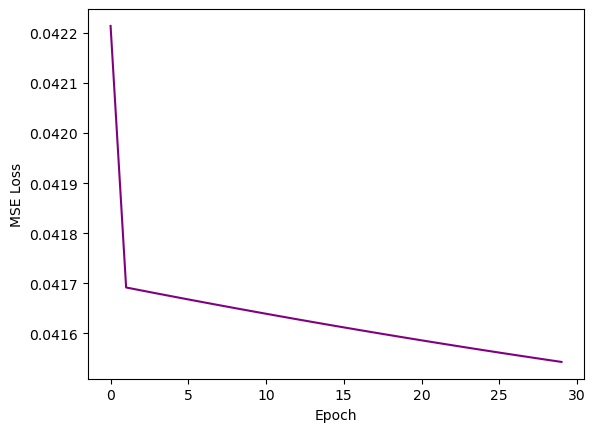

In [76]:
plt.plot(np.array(e), np.array(l), color='purple')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

In [77]:
PATH = './tree_model.pth'
torch.save(model.state_dict(), PATH)

In [83]:
model = myModel(input_dim, hidden_dim, output_dim)
model.load_state_dict(torch.load(PATH))

with torch.no_grad():
    total_loss = 0.0
    temp = x_test
    rand_vector = random.sample(range(0, len(temp) -1),random.randint((len(temp)-1)//2, len(temp)-1))
    selected = [temp[i] for i in rand_vector]
    predictions = []
    labels = []
    
    temp1 = y_test
    selected_test = [temp1[i] for i in rand_vector]

    for i in range(len(selected)):
        predict_y = model(selected[i]).squeeze(0)
        predictions.append(predict_y.detach().numpy())
        labels.append(selected_test[i].detach().numpy())
        loss = loss_func(predict_y, selected_test[i])
        total_loss += loss.item()
    loss = total_loss/len(selected)
    print(f'MSE Loss: {loss / (i + 1):.5f}')


MSE Loss: 0.00002


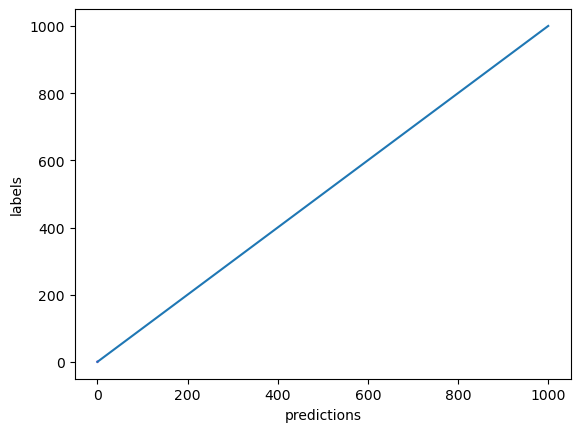

In [85]:
plt.plot(predictions, labels, color = 'violet')
plt.xlabel("predictions")
plt.ylabel("labels")
plt.plot([0,1000],[0,1000])